In [ ]:
# Main file for the project
import glob
import time
from sklearn.svm import LinearSVC
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
import matplotlib

# Now to detect images, get the frame, iterate (windows) then check if there is a car in the box!
# test car detection on test images
from utilities import slide_window, draw_boxes
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
# Train network
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from utilities import draw_boxes, extract_features, add_heat, apply_threshold, draw_labeled_bboxes
from PIL import Image
import PIL





plt.interactive(False)
# Prepare data, first read images of cars and not cars, then extract features,
# the labels will just be a 1 for CAR and a 0 for "NOT CAR"

# Read images from dataset
img_cars_files = glob.glob("dataset\\vehicles_smallset\\**\\*.jpeg",recursive= True)
img_notcars_files = glob.glob("dataset\\non-vehicles_smallset\\**\\*.jpeg",recursive= True)
img_cars_files = glob.glob("dataset\\vehicles\\**\\*.png",recursive= True)
img_notcars_files = glob.glob("dataset\\non-vehicles\\**\\*.png",recursive= True)

img_cars = []
img_not_cars = []
max_samples = 10000 # just to use less data and speedup during prototyping
for image_file in img_cars_files[0:max_samples]:
    img_cars.append(image_file)
for image_file in img_notcars_files[0:max_samples]:
    img_not_cars.append(image_file)

# Extract features from images of cars and not-cars
car_features = extract_features(img_cars)
notcar_features = extract_features(img_not_cars)

X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Create corresponding labels
y = np.hstack((np.ones(len(car_features)),
              np.zeros(len(notcar_features))))
n_classes = 2

# Create an array stack of feature vectors
## Split dataset into training and test set
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

# Scale features
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

from time import time
#clf = LinearSVC()
# Check the training time for the SVC
#t = time()
#clf.fit(scaled_X_train, y_train)
#t2 =  time()
#print(round(t2-t, 2), 'Seconds to train SVC...')

# GridSeachCV Is very slow, but I can use it to find the best parameters for SVC
#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 100], }
#parameters = [
#  {'C': [1, 10, 100], 'kernel': ['linear']},
#  {'C': [1, 10, 100], 'gamma': [0.001, 0.0001, 0.00001], 'degree': [2, 3, 4], 'kernel': ['rbf']},
# ]
#svc = svm.SVC(cache_size=1000)
#clf = GridSearchCV(svc, parameters, return_train_score=False, n_jobs=8)
clf = svm.SVC(C=10, cache_size=1000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.005, verbose=False)

print("Fitting the classifier to the training set")
t0 = time()
clf.fit(scaled_X_train, y_train)
print("done in %0.3fs" % (time() - t0))

#print("Best estimator found by grid search:")
#print(clf.best_estimator_)

print("Predicting...")
t0 = time()
y_pred = clf.predict(scaled_X_test)
print("done in %0.3fs" % (time() - t0))

print("Classification report")
print(classification_report(y_test, y_pred, target_names=['Car','Not Car']))
print("Confusion matrix")
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


In [30]:
import PIL
def detect_cars(frame):
    detected_windows = []
    # Classification step
    X_show = True
    for window in windows:
        cropped_fig = frame[window[0][1]:window[1][1], window[0][0]:window[1][0]]
        # need to resize to a 64 by 64 image to classify
        dst = cv2.resize(cropped_fig, (64, 64), interpolation=cv2.INTER_NEAREST)
        # Classify
        X = extract_features(dst,
                             c_space='YUV',
                             spatial_size=(32, 32),
                             hist_bins=32,
                             hist_range=(0, 256),
                             hog_channels=2,
                             hog_orient=11,
                             hog_pix_per_cell=16,
                             hog_cell_per_block=2)
        # Apply the scaler to X_train and X_test
        scaled_X = X_scaler.transform([np.array(X)])
        Y_pred = clf.predict(scaled_X)
        if X_show:
            #print("Mean Std X: {}, {}".format(np.mean(X), np.std(X)))
            #print("Scald MS X: {}, {}".format(np.mean(scaled_X), np.std(scaled_X)))
            X_show = False
        if Y_pred:
            detected_windows.append(window)
            # cv2.rectangle(frame, (window[0][0],window[1][0]),(window[0][1],window[1][1]), (0, 0, 255), 6)

    heat = np.zeros_like(frame[:, :, 0]).astype(np.float)
    # Add heat to each box in box list
    heatmap = add_heat(heat, detected_windows)

    # Apply threshold to help remove false positives
    heatmap = apply_threshold(heatmap, threshold=1)

    # Clip heatmap
    heatmap = np.clip(heatmap, 0, 255)
    #print(np.amin(heatmap))
    #print(np.amax(heatmap))
    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    draw_img = draw_labeled_bboxes(np.copy(frame), labels)

    heatmap *= 255
    heatmap = np.uint8(np.clip(heatmap, 0, 255))

    # Add heatmap to frame (top left corner)
    img_w, img_h = (320, 240)
    bg_w, bg_h = (1280, 720)
    offset = ((bg_w - img_w) // 8, (bg_h - img_h) // 8)
    heatmap_small = cv2.resize(heatmap, (320, 240))
    heatmap_small_pip = PIL.Image.fromarray(heatmap_small)

    draw_img_pip = PIL.Image.fromarray(draw_img)
    draw_img_pip.paste(heatmap_small_pip, offset)
    draw_img_return = np.array(draw_img_pip)
    # draw_img = draw_boxes(frame, detected_windows, thickness=3)
    return draw_img_return

In [31]:

test_image = mpimg.imread("test_images\\test2.jpg")
windows = slide_window(test_image,
                       (int(test_image.shape[1]*1/3), test_image.shape[1]),
                       (int(test_image.shape[0] / 2), int(test_image.shape[0]*8/10)),
                       xy_window=(int(test_image.shape[0] / 4), int(test_image.shape[0] / 4)))

for den in [6, 8, 10]:
    windows += slide_window(test_image,
                            (int(test_image.shape[1]*1/3), test_image.shape[1]),
                            (int(test_image.shape[0] / 2), int(test_image.shape[0]*8/10)),
                            xy_window=(int(test_image.shape[0] / den), int(test_image.shape[0] / den)))

# Explore data
imcopy = draw_boxes(test_image, windows, thickness=3)

for window in windows:
    cropped_fig = test_image[window[0][1]:window[1][1], window[0][0]:window[1][0]]
    # need to resize to a 64 by 64 image to classify
    dst = cv2.resize(cropped_fig, (64, 64), interpolation=cv2.INTER_CUBIC)


# Extract image features, then subsample it (to obtain the "featured window", which needs to be classified (car/not car)
test_image = mpimg.imread("test_images\\test6.jpg")

frame = test_image
from utilities import draw_boxes, extract_features
from tqdm import tqdm

detected_windows = []


imcopy = draw_boxes(frame, detected_windows, thickness=3)
#plt.figure()
#plt.imshow(imcopy)
frame = test_image
import time




test_images = glob.glob('./test_images/test*.jpg')


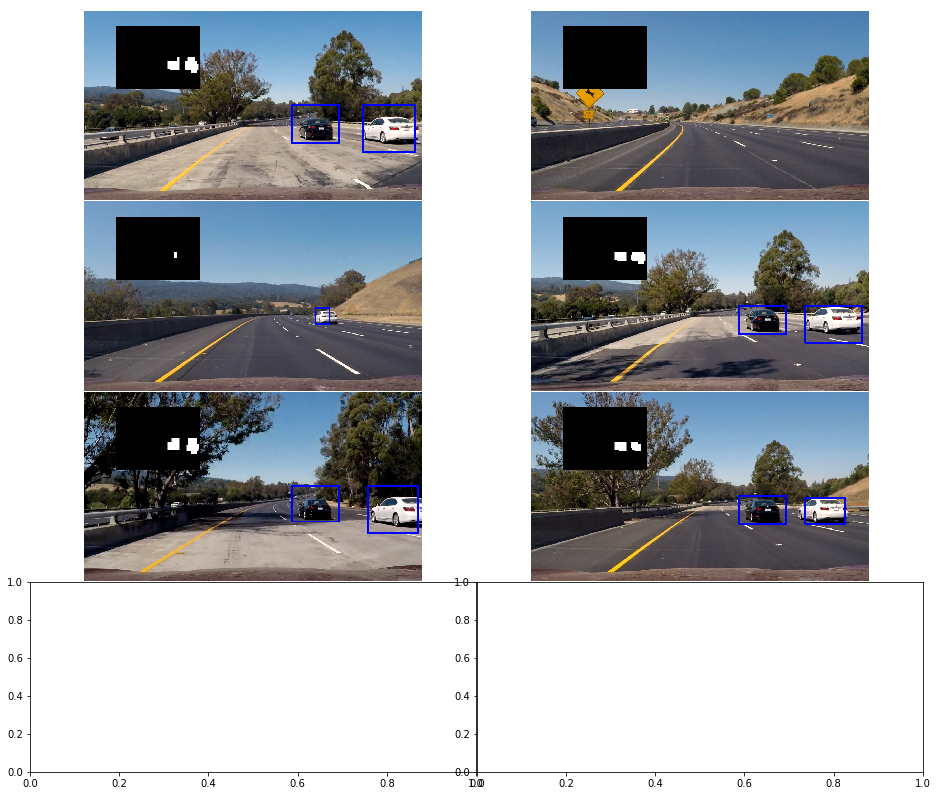

In [32]:
test_images = glob.glob('./test_images/test*.jpg')
plt.interactive(False)
fig, axs = plt.subplots(4, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images[0:6]):
    axs[i].imshow(detect_cars(mpimg.imread(im)))
    axs[i].axis('off')
plt.show()


In [ ]:

timestr = time.strftime("%Y%m%d-%H%M%S")
print("Generating video output!")
project_video_output = 'project_video_out-' + timestr + '.mp4'
clip = VideoFileClip('project_video3.mp4').subclip(23,24)
out_clip = clip.fl_image(detect_cars)
print("Writing video output to file...")
out_clip.write_videofile(project_video_output, audio=False)
print("Done")
import os
os.startfile(project_video_output)


Generating video output!

Writing video output to file...

[MoviePy] >>>> Building video project_video_out-20180520-155246.mp4


[MoviePy] Writing video project_video_out-20180520-155246.mp4


  0%|                                                      | 0/26 [00:00<?, ?it/s]

  4%|█▊                                            | 1/26 [00:03<01:34,  3.79s/it]

  8%|███▌                                          | 2/26 [00:07<01:30,  3.78s/it]

 12%|█████▎                                        | 3/26 [00:11<01:27,  3.81s/it]

 15%|███████                                       | 4/26 [00:15<01:24,  3.84s/it]

 19%|████████▊                                     | 5/26 [00:19<01:20,  3.83s/it]

 23%|██████████▌                                   | 6/26 [00:23<01:16,  3.84s/it]

 27%|████████████▍                                 | 7/26 [00:27<01:14,  3.90s/it]

 31%|██████████████▏                               | 8/26 [00:31<01:10,  3.94s/it]

 35%|███████████████▉                              | 9/26 [00:35<01:06,  3.93s/it]

 38%|█████████████████▎                           | 10/26 [00:39<01:02,  3.91s/it]

 42%|███████████████████                          | 11/26 [00:42<00:58,  3.90s/it]

 46%|████████████████████▊                        | 12/26 [00:46<00:54,  3.90s/it]

 50%|██████████████████████▌                      | 13/26 [00:51<00:51,  3.93s/it]

 54%|████████████████████████▏                    | 14/26 [00:55<00:47,  3.95s/it]

 58%|█████████████████████████▉                   | 15/26 [00:59<00:43,  3.96s/it]

 62%|███████████████████████████▋                 | 16/26 [01:03<00:39,  3.96s/it]

 65%|█████████████████████████████▍               | 17/26 [01:07<00:35,  3.97s/it]

 69%|███████████████████████████████▏             | 18/26 [01:11<00:31,  3.98s/it]

 73%|████████████████████████████████▉            | 19/26 [01:15<00:27,  3.98s/it]

 77%|██████████████████████████████████▌          | 20/26 [01:19<00:23,  3.98s/it]

 81%|████████████████████████████████████▎        | 21/26 [01:24<00:20,  4.00s/it]

 85%|██████████████████████████████████████       | 22/26 [01:27<00:15,  4.00s/it]

 88%|███████████████████████████████████████▊     | 23/26 [01:31<00:11,  3.99s/it]

 92%|█████████████████████████████████████████▌   | 24/26 [01:35<00:07,  3.98s/it]

 96%|███████████████████████████████████████████▎ | 25/26 [01:39<00:03,  3.97s/it]

[MoviePy] Done.


[MoviePy] >>>> Video ready: project_video_out-20180520-155246.mp4 



Done